# Transformer-based NLP classifier for IMDB reviews

A pretrained transformers model (bert-base-uncased) was fine-tuned to act as a classifier for sentiment analysis on the IMDB reviews dataset.

### Data
The IMDB dataset has 50K movie reviews for binary sentiment classification through natural language processing (NLP). This dataset can be downloaded at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/

### Neural network
BERT base model (uncased)
BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. It was pretrained on the raw texts only, with no humans labeling.

It was pretrained with two objectives:

1) Masked language modeling (MLM): taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. 
2) Next sentence prediction (NSP): the models concatenates two masked sentences as inputs during pretraining. Sometimes they correspond to sentences that were next to each other in the original text, sometimes not. The model then has to predict if the two sentences were following each other or not.

Paper link: https://arxiv.org/abs/1810.04805

### Important libraries
1) PyTorch (https://pytorch.org)
2) Transformers (https://huggingface.co/)
3) scikit-learn (https://scikit-learn.org/stable/)

In [1]:
import pandas as pd
import os, sys
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn
from datasets import Dataset, DatasetDict
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

## Prepare data

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Cleaning the data
1) Drop the columns not necessary for this analysis. 
2) Remove rows with no entries.
3) Renumber the labels

In [3]:
df['input'] = df['review']
df.loc[df['sentiment']=='positive','labels'] = 1
df.loc[df['sentiment']=='negative','labels'] = 0
df['labels'] = df['labels'].astype('int')
df.drop(columns=['sentiment','review'],inplace=True)
df.dropna(inplace=True)
df.head()

,input,labels
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Visualizing the data distribution

In [4]:
df_pie = df['labels'].value_counts()
df_pie.head()

1    25000
0    25000
Name: labels, dtype: int64

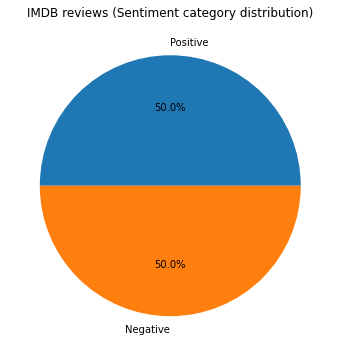

In [5]:
# Brief summary of the data
labels = ['Positive','Negative']
# sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df_pie, labels=labels, autopct='%1.1f%%')
plt.title('IMDB reviews (Sentiment category distribution)')
plt.show()

## Tokenization

In [6]:
ds = Dataset.from_pandas(df)

In [7]:
model_nm = 'bert-base-uncased'

In [8]:
tokz = AutoTokenizer.from_pretrained(model_nm)
tokz.model_max_length = 512

In [9]:
def tok_func(x):
    return tokz(x["input"],truncation=True)

In [10]:
tok_ds = ds.map(tok_func, batched=True)
dds = tok_ds.train_test_split(0.2, seed=77)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Evaluation metrics
1) Balanced accuracy score
2) F1 score

In [11]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = balanced_accuracy_score(labels,predictions)
    f1 = f1_score(labels, predictions, average = 'micro')
    return {'accuracy': acc, 'f1_score': f1}

## Training

In [12]:
torch.cuda.is_available()

True

In [13]:
bs = 16 # Batch size
epochs = 5 # number of epochs
lr = 2e-5 # Learning rate
num_class = 2 # Number of classes of sentiments (positive and negative)

In [14]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=num_class)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=compute_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.201100,0.225823,0.923167,0.922500
2,0.152100,0.216666,0.939809,0.939500
3,0.078800,0.245679,0.944636,0.944700
4,0.025400,0.304898,0.946054,0.945900
5,0.016300,0.318738,0.947421,0.947400


TrainOutput(global_step=12500, training_loss=0.11355635234832763, metrics={'train_runtime': 6903.4504, 'train_samples_per_second': 28.971, 'train_steps_per_second': 1.811, 'total_flos': 5.200281475880064e+16, 'train_loss': 0.11355635234832763, 'epoch': 5.0})

### Save the model

In [17]:
trainer.save_model('trained_model_imdb')

### Loading a trained model

In [18]:
# Load model (uncomment the following lines to load a fine-tuned model)
# model = AutoModelForSequenceClassification.from_pretrained('trained_model_imdb')
# trainer = Trainer(model,tokenizer=tokz)

## Prediction

In [19]:
y = trainer.predict(dds['test']).predictions.astype(float)